In [1]:
import sys
import os

package_path: str = ".."
if package_path not in sys.path:
    sys.path.append(package_path)

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
from src.integrator.loader import PalXFELLoader
from src.config import load_config
from src.filesystem import get_run_scan_dir


config = load_config()

run_n: int = 168
scan_n: int = 1
p_n: int = 1
file = get_run_scan_dir(config.path.load_dir, run_n, scan_n, sub_path=f"p{p_n:04}.h5")
print(f"Data from '{config.path.load_dir}'")
print(f"{run_n=}, {scan_n=}, {p_n=}")
loader = PalXFELLoader(file)
data = loader.get_data()

for key, value in data.items():
    print(f"key: {key}, shape: {value.shape}")

Data from 'F:\240821_PAL_delay'
run_n=168, scan_n=1, p_n=1


2025-08-14 06:47:17.164 | INFO     | src.integrator.loader:__init__:76 - Loaded 300 images and 300 qbpm data.
2025-08-14 06:47:17.166 | INFO     | src.integrator.loader:__init__:79 - Pump state distribution: 150 on, 150 off.


key: delay, shape: ()
key: poff, shape: (150, 514, 1030)
key: poff_qbpm, shape: (150,)
key: pon, shape: (150, 514, 1030)
key: pon_qbpm, shape: (150,)


In [4]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from roi_rectangle import RoiRectangle

matplotlib.rcParams['font.family'] = 'Malgun Gothic'

plt.rcParams['axes.unicode_minus'] = False

ROI: RoiRectangle(x1=340, y1=92, x2=430, y2=171)


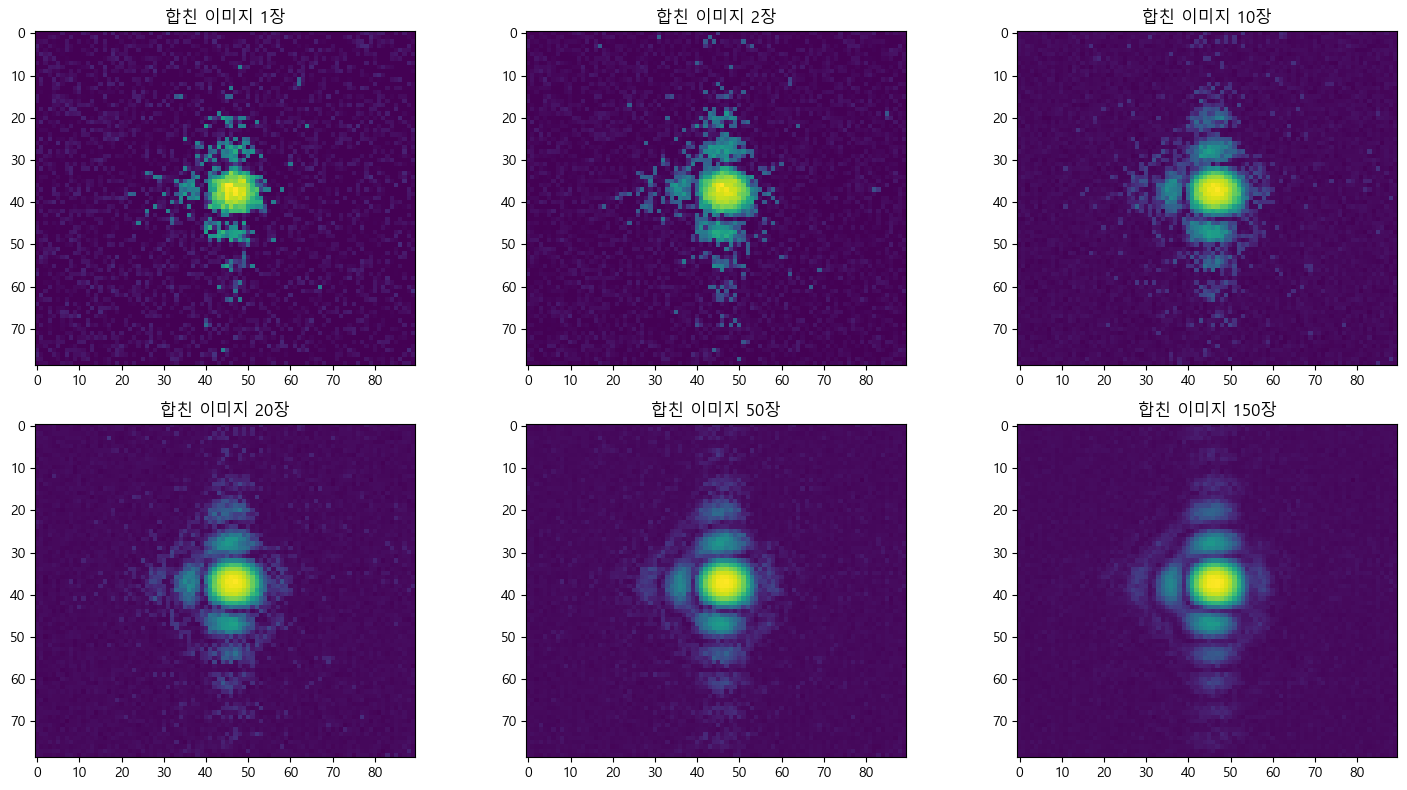

In [5]:
poff_images = data["poff"]
pon_images = data["pon"]
poff_qbpms = data["poff_qbpm"]
pon_qbpms = data["pon_qbpm"]
poff_intensities = poff_images.sum(axis=(1, 2))
pon_intensities = pon_images.sum(axis=(1, 2))
rect = RoiRectangle(x1=340, y1=92, x2=430, y2=171)

num: int = 150
summed_image = rect.slice(np.sum(poff_images[:num], axis=0))
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
for ax, num in zip(axs.ravel(), [1, 2, 10, 20, 50, 150]):
    summed_image = rect.slice(np.sum(poff_images[:num], axis=0)) / num
    ax.set_title(f"합친 이미지 {num}장")
    ax.imshow(np.log1p(summed_image))

fig.tight_layout()
# fig.savefig('high_res_plot.png', dpi=300)

print(f"ROI: {rect}")

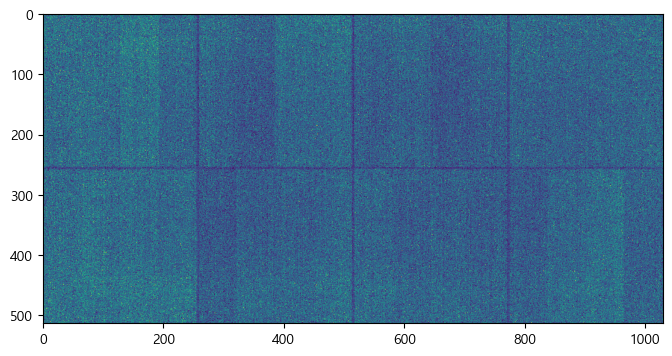

In [6]:
dark_file = config.path.analysis_dir / "dark_images" / "dark.npy"
dark_images = np.load(dark_file)

fig, axs = plt.subplots(1, 1, figsize=(8, 6))
axs.imshow(np.log2(dark_images[0] + 1), vmin=0, vmax=0.6)

plt.show()

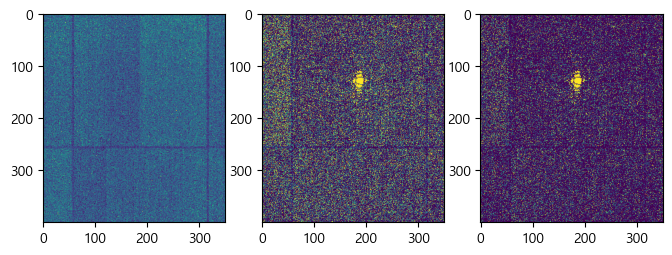

In [7]:


roi_rect = RoiRectangle(200, 0, 550, 400)
dark = roi_rect.slice(dark_images[0])
img = roi_rect.slice(pon_images[2])
dark = np.maximum(dark, 0)
img = np.maximum(img, 0)

img_sub_dark = np.maximum(img - dark, 0)

fig, axs = plt.subplots(1, 3, figsize=(8, 12))
axs[0].imshow(np.log2(dark + 1), vmin=0, vmax=0.6)
axs[1].imshow(np.log2(img + 1), vmin=0, vmax=0.6)
axs[2].imshow(np.log2(img_sub_dark + 1), vmin=0, vmax=0.6)
# fig.colorbar(im0, ax=axs, location='right', fraction=0.05)
plt.show()

C:\Users\isaac\AppData\Local\Temp\ipykernel_7340\2604828083.py:14: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  Z = np.trapz(g, E)
C:\Users\isaac\AppData\Local\Temp\ipykernel_7340\2604828083.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(pdf[mask], E[mask]))


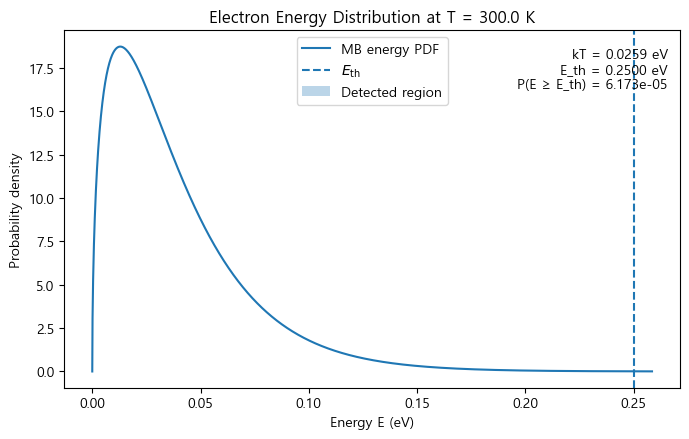

In [8]:
import numpy as np
import matplotlib.pyplot as plt

kB_eV = 8.617333262e-5  # Boltzmann constant [eV/K]

def mb_pdf_energy(E: np.ndarray, T: float) -> np.ndarray:
    """
    3D Maxwell–Boltzmann 전자 에너지 분포 (정규화된 PDF).
    f(E) ∝ sqrt(E) * exp(-E/(k_B T)),  E >= 0
    """
    beta = 1.0 / (kB_eV * T)
    g = np.sqrt(np.clip(E, 0, None)) * np.exp(-beta * np.clip(E, 0, None))
    # 수치적 정규화
    Z = np.trapz(g, E)
    return g / Z if Z > 0 else g

def tail_probability(E: np.ndarray, pdf: np.ndarray, E_th: float) -> float:
    """E >= E_th 꼬리 확률."""
    mask = E >= E_th
    if not np.any(mask):
        return 0.0
    return float(np.trapz(pdf[mask], E[mask]))

def plot_energy_distribution(
    T: float = 300.0,
    E_th: float = 0.2,
    E_max: float | None = None,
    annotate: bool = True
):
    """
    T [K]에서의 전자 에너지 분포와 임계 에너지 E_th [eV]를 시각화.
    - E_max를 지정하지 않으면 10 kT로 설정.
    """
    if E_max is None:
        E_max = 10.0 * kB_eV * T

    # 에너지 축 (0 ~ E_max)
    E = np.linspace(0.0, E_max, 2000)
    pdf = mb_pdf_energy(E, T)
    p_tail = tail_probability(E, pdf, E_th)

    # 플롯 (단일 축, 색 지정 없음)
    fig, ax = plt.subplots(figsize=(7, 4.5))
    ax.plot(E, pdf, label="MB energy PDF")

    # 임계 에너지 표시
    ax.axvline(E_th, linestyle="--", linewidth=1.5, label=r"$E_{\mathrm{th}}$")

    # 꼬리 영역 음영
    mask = E >= E_th
    if np.any(mask):
        ax.fill_between(E[mask], pdf[mask], step=None, alpha=0.3, label="Detected region")

    ax.set_xlabel("Energy E (eV)")
    ax.set_ylabel("Probability density")
    ax.set_title(f"Electron Energy Distribution at T = {T:.1f} K")
    ax.legend(loc="best")

    if annotate:
        kt = kB_eV * T
        txt = (f"kT = {kt:.4f} eV\n"
               f"E_th = {E_th:.4f} eV\n"
               f"P(E ≥ E_th) = {p_tail:.3e}")
        ax.text(0.98, 0.95, txt, transform=ax.transAxes,
                ha="right", va="top")

    plt.tight_layout()
    plt.show()
    return {"E": E, "pdf": pdf, "tail_prob": p_tail}

if __name__ == "__main__":
    # 예시: T=300 K, 임계 에너지 0.25 eV
    plot_energy_distribution(T=300.0, E_th=0.25)


In [9]:
np.min(img - dark + 1)

np.float32(-0.86583745)

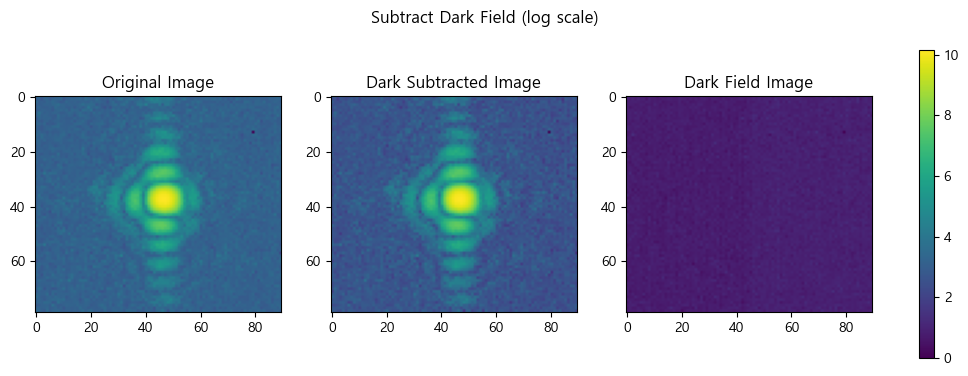

In [10]:
from src.preprocessor.generic_preprocessors import subtract_dark
images = rect.slice(pon_images)
dark_sub_images = rect.slice(subtract_dark(pon_images))

dark_file = config.path.analysis_dir / "dark_images" / "dark.npy"
dark_images = np.load(dark_file)

vmin, vmax = images.sum(0).min(), images.sum(0).max()

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle("Subtract Dark Field (log scale)")

im0 = axs[0].imshow(np.log1p(images.sum(0)), vmin=np.log1p(vmin), vmax=np.log1p(vmax))
axs[0].set_title("Original Image")

im1 = axs[1].imshow(np.log1p(dark_sub_images.sum(0)), vmin=np.log1p(vmin), vmax=np.log1p(vmax))
axs[1].set_title("Dark Subtracted Image")

im2 = axs[2].imshow(np.log1p(rect.slice(dark_images).sum(0)), vmin=np.log1p(vmin), vmax=np.log1p(vmax))
axs[2].set_title("Dark Field Image")

fig.colorbar(im0, ax=axs, location='right', fraction=0.05)

plt.show()

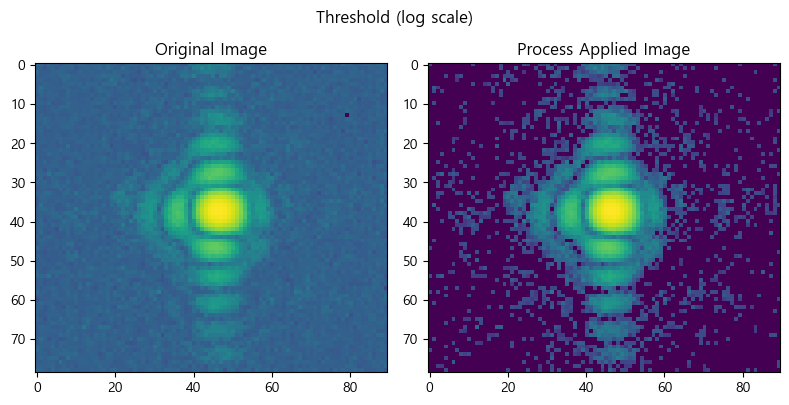

In [11]:
n: float = 4
thres_images = np.where(images > n, images, 0)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle("Threshold (log scale)")
axs[0].imshow(np.log1p(images.sum(0)))
axs[0].set_title("Original Image")
axs[1].imshow(np.log1p(thres_images.sum(0)))
axs[1].set_title("Process Applied Image")
fig.tight_layout()

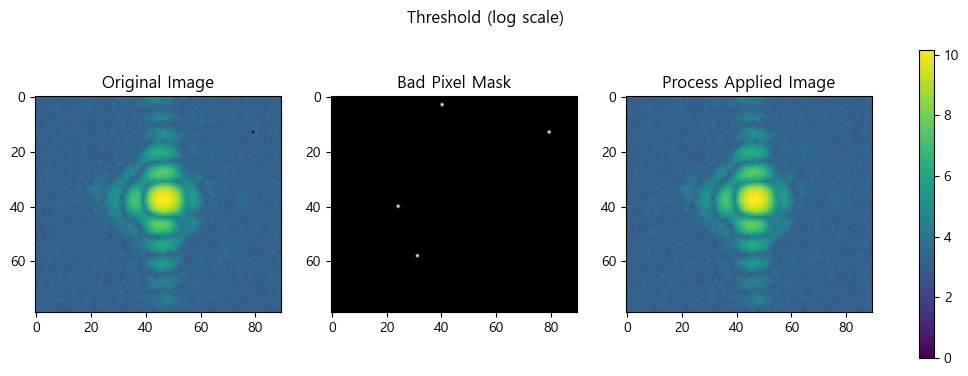

In [12]:
from scipy.ndimage import median_filter

def detect_bad_pixels_single_frame(frame, hot_factor=5.0, low_value=1e-3, window_size=3):
    """
    한 프레임에서 주변 대비 값이 비정상적으로 높은(HOT) 또는 낮은(DEAD) 픽셀 검출.
    """
    med_local = median_filter(frame, size=window_size, mode='reflect')
    hot_mask = frame > med_local * hot_factor
    dead_mask = frame < low_value
    return hot_mask | dead_mask

def remove_bad_pixels(frames, bad_mask, window_size=3):
    """불량 픽셀만 주변 median 값으로 대체."""
    out = frames.copy()
    for i in range(frames.shape[0]):
        med_img = median_filter(frames[i], size=window_size, mode='reflect')
        out[i][bad_mask] = med_img[bad_mask]
    return out

# 예시 사용
# 한 프레임에서 불량 픽셀 마스크 생성
# bad_mask = sum(detect_bad_pixels_single_frame(pon_images.mean(0), 3), np.zeros_like())
bad_mask = detect_bad_pixels_single_frame(images.mean(0), 2.5)
# 모든 프레임에 동일 마스크 적용
frames_no_bad = remove_bad_pixels(images, bad_mask)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle("Threshold (log scale)")
im0 = axs[0].imshow(np.log1p(images.sum(0)), vmin=np.log1p(vmin), vmax=np.log1p(vmax))
axs[0].set_title("Original Image")
im1 = axs[1].imshow(bad_mask, cmap='gray')
axs[1].set_title("Bad Pixel Mask")
im2 = axs[2].imshow(np.log1p(frames_no_bad.sum(0)), vmin=np.log1p(vmin), vmax=np.log1p(vmax))
axs[2].set_title("Process Applied Image")

fig.colorbar(im0, ax=axs, location='right', fraction=0.05)


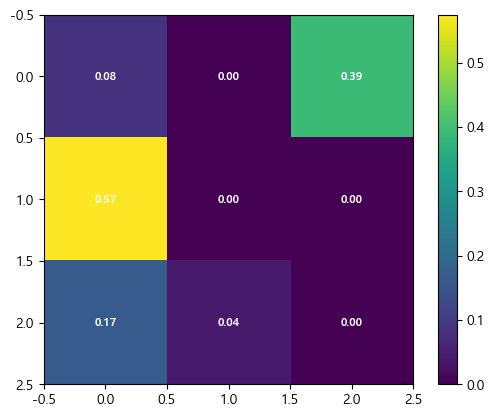

In [13]:
# 예시: 기존 데이터
ys, xs = np.where(bad_mask != 0)
y, x = ys[0], xs[0]
img = images[0]

fig, ax = plt.subplots(1, 1)
sub_img = img[y-1:y+2, x-1:x+2]  # 3x3 영역
im = ax.imshow(sub_img, cmap='viridis')

# 픽셀 값 표시
for i in range(sub_img.shape[0]):       # 행
    for j in range(sub_img.shape[1]):   # 열
        ax.text(j, i, f"{sub_img[i, j]:.2f}",
                ha='center', va='center',
                color='white', fontsize=8,
                fontweight='bold')

fig.colorbar(im, ax=ax, location='right', fraction=0.05)
plt.show()


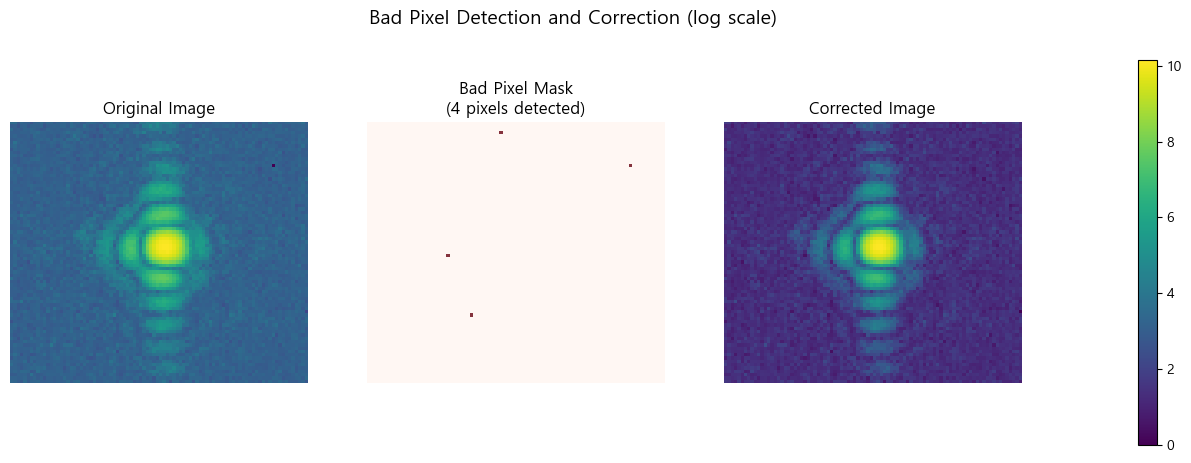

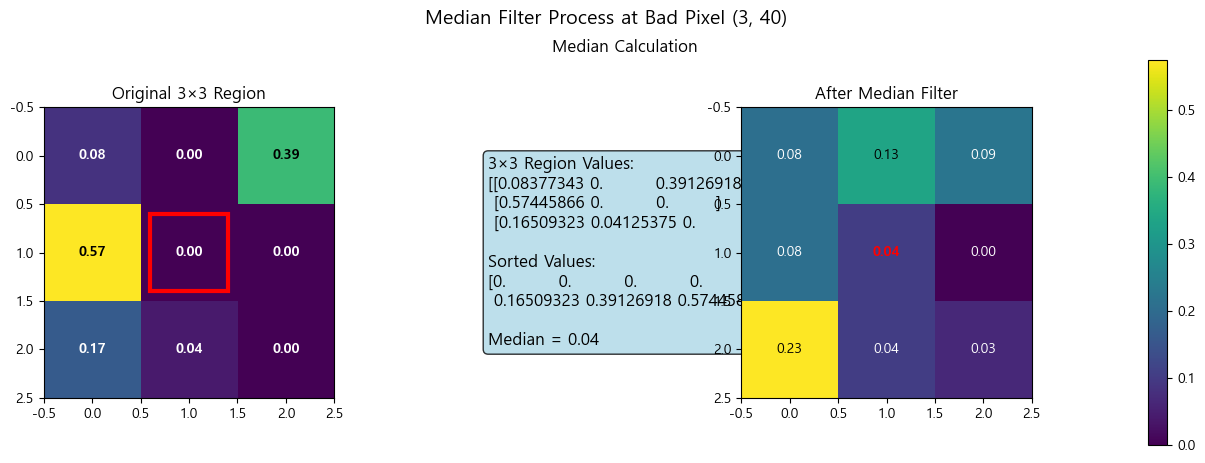


Bad pixel at (3, 40):
  Original value: 0.00
  Corrected value: 0.04
  Change: 0.00 → 0.04


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter

def detect_bad_pixels_single_frame(frame, hot_factor=5.0, low_value=1e-3, window_size=3):
    """
    한 프레임에서 주변 대비 값이 비정상적으로 높은(HOT) 또는 낮은(DEAD) 픽셀 검출.
    
    Parameters:
    -----------
    frame : np.ndarray
        입력 프레임
    hot_factor : float
        HOT 픽셀 판정 임계값 (median 대비 배수)
    low_value : float
        DEAD 픽셀 판정 임계값 (절대값)
    window_size : int
        median filter 윈도우 크기
    
    Returns:
    --------
    bad_mask : np.ndarray (bool)
        불량 픽셀 마스크
    """
    med_local = median_filter(frame, size=window_size, mode='reflect')
    hot_mask = frame > med_local * hot_factor
    dead_mask = frame < low_value
    return hot_mask | dead_mask

def remove_bad_pixels(frames, bad_mask, window_size=3):
    """
    불량 픽셀만 주변 median 값으로 대체.
    
    Parameters:
    -----------
    frames : np.ndarray
        입력 프레임들 (3D array)
    bad_mask : np.ndarray (bool)
        불량 픽셀 마스크
    window_size : int
        median filter 윈도우 크기
    
    Returns:
    --------
    out : np.ndarray
        보정된 프레임들
    """
    out = frames.copy()
    for i in range(frames.shape[0]):
        med_img = median_filter(frames[i], size=window_size, mode='reflect')
        out[i][bad_mask] = med_img[bad_mask]
    return out

def visualize_bad_pixel_correction(images, vmin=None, vmax=None, hot_factor=2.5):
    """
    불량 픽셀 검출 및 보정 과정을 시각화
    """
    # 불량 픽셀 마스크 생성
    bad_mask = detect_bad_pixels_single_frame(images.mean(0), hot_factor)
    
    # 불량 픽셀 보정
    frames_no_bad = remove_bad_pixels(images, bad_mask)
    
    # 전체 비교 시각화
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle("Bad Pixel Detection and Correction (log scale)", fontsize=14)
    
    # 원본 이미지
    im0 = axs[0].imshow(np.log1p(images.sum(0)), vmin=np.log1p(vmin) if vmin else None, 
                        vmax=np.log1p(vmax) if vmax else None, cmap='viridis')
    axs[0].set_title("Original Image")
    axs[0].axis('off')
    
    # 불량 픽셀 마스크
    im1 = axs[1].imshow(bad_mask, cmap='Reds', alpha=0.8)
    axs[1].set_title(f"Bad Pixel Mask\n({np.sum(bad_mask)} pixels detected)")
    axs[1].axis('off')
    
    # 보정된 이미지
    im2 = axs[2].imshow(np.log1p(frames_no_bad.sum(0)), vmin=np.log1p(vmin) if vmin else None, 
                        vmax=np.log1p(vmax) if vmax else None, cmap='viridis')
    axs[2].set_title("Corrected Image")
    axs[2].axis('off')
    
    # 컬러바 추가
    fig.colorbar(im0, ax=axs, location='right', fraction=0.03, pad=0.1)
    # plt.tight_layout()
    plt.show()
    
    return bad_mask, frames_no_bad

def visualize_median_filter_process(images, bad_mask, pixel_index=0, frame_index=0):
    """
    특정 불량 픽셀에 대한 median filter 적용 과정을 상세히 시각화
    """
    # 불량 픽셀 위치 찾기
    ys, xs = np.where(bad_mask != 0)
    if len(ys) == 0:
        print("No bad pixels found!")
        return
    
    if pixel_index >= len(ys):
        pixel_index = 0
        print(f"Using first bad pixel (index 0)")
    
    y, x = ys[pixel_index], xs[pixel_index]
    img = images[frame_index]
    
    # 3x3 영역 추출
    y_start, y_end = max(0, y-1), min(img.shape[0], y+2)
    x_start, x_end = max(0, x-1), min(img.shape[1], x+2)
    sub_img = img[y_start:y_end, x_start:x_end]
    
    # median filter 적용
    med_img = median_filter(img, size=3, mode='reflect')
    sub_med = med_img[y_start:y_end, x_start:x_end]
    
    # 시각화
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Median Filter Process at Bad Pixel ({y}, {x})', fontsize=14)
    
    # 1. 원본 3x3 영역
    im1 = axs[0].imshow(sub_img, cmap='viridis')
    axs[0].set_title('Original 3×3 Region')
    
    # 픽셀 값 표시
    for i in range(sub_img.shape[0]):
        for j in range(sub_img.shape[1]):
            color = 'white' if sub_img[i, j] < sub_img.max() * 0.5 else 'black'
            axs[0].text(j, i, f"{sub_img[i, j]:.2f}",
                       ha='center', va='center',
                       color=color, fontsize=10, fontweight='bold')
    
    # 중심 픽셀 강조 (불량 픽셀)
    center_y, center_x = sub_img.shape[0]//2, sub_img.shape[1]//2
    axs[0].add_patch(plt.Rectangle((center_x-0.4, center_y-0.4), 0.8, 0.8, 
                                  fill=False, edgecolor='red', linewidth=3))
    
    # 2. Median 계산 과정 보여주기
    axs[1].axis('off')
    axs[1].set_title('Median Calculation')
    
    # 3x3 영역의 값들을 정렬하여 표시
    values = sub_img.flatten()
    sorted_values = np.sort(values)
    median_value = np.median(values)
    
    text_content = "3×3 Region Values:\n"
    text_content += f"{values.reshape(sub_img.shape)}\n\n"
    text_content += "Sorted Values:\n"
    text_content += f"{sorted_values}\n\n"
    text_content += f"Median = {median_value:.2f}"
    
    axs[1].text(0.1, 0.5, text_content, fontsize=12, verticalalignment='center',
               bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.8))
    
    # 3. 보정된 3x3 영역
    im3 = axs[2].imshow(sub_med, cmap='viridis')
    axs[2].set_title('After Median Filter')
    
    # 픽셀 값 표시
    for i in range(sub_med.shape[0]):
        for j in range(sub_med.shape[1]):
            color = 'white' if sub_med[i, j] < sub_med.max() * 0.5 else 'black'
            # 보정된 픽셀은 빨간색으로 표시
            if i == center_y and j == center_x:
                color = 'red'
                fontweight = 'bold'
            else:
                fontweight = 'normal'
            axs[2].text(j, i, f"{sub_med[i, j]:.2f}",
                       ha='center', va='center',
                       color=color, fontsize=10, fontweight=fontweight)
    
    # 컬러바 추가
    fig.colorbar(im1, ax=[axs[0], axs[2]], location='right', fraction=0.05, pad=0.1)
    
    # plt.tight_layout()
    plt.show()
    
    print(f"\nBad pixel at ({y}, {x}):")
    print(f"  Original value: {img[y, x]:.2f}")
    print(f"  Corrected value: {med_img[y, x]:.2f}")
    print(f"  Change: {img[y, x]:.2f} → {med_img[y, x]:.2f}")

# 사용 예시:
bad_mask, frames_corrected = visualize_bad_pixel_correction(images, vmin, vmax)
visualize_median_filter_process(images, bad_mask, pixel_index=0, frame_index=0)

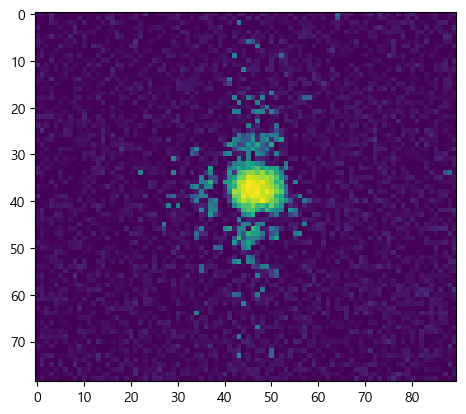

In [15]:
# Noise Summerize
img = images[0]
fig, axs = plt.subplots(1, 1)
axs.imshow(np.log1p(img))

Text(0, 0.5, 'Intensity to QBPM Ratios (a.u.)')

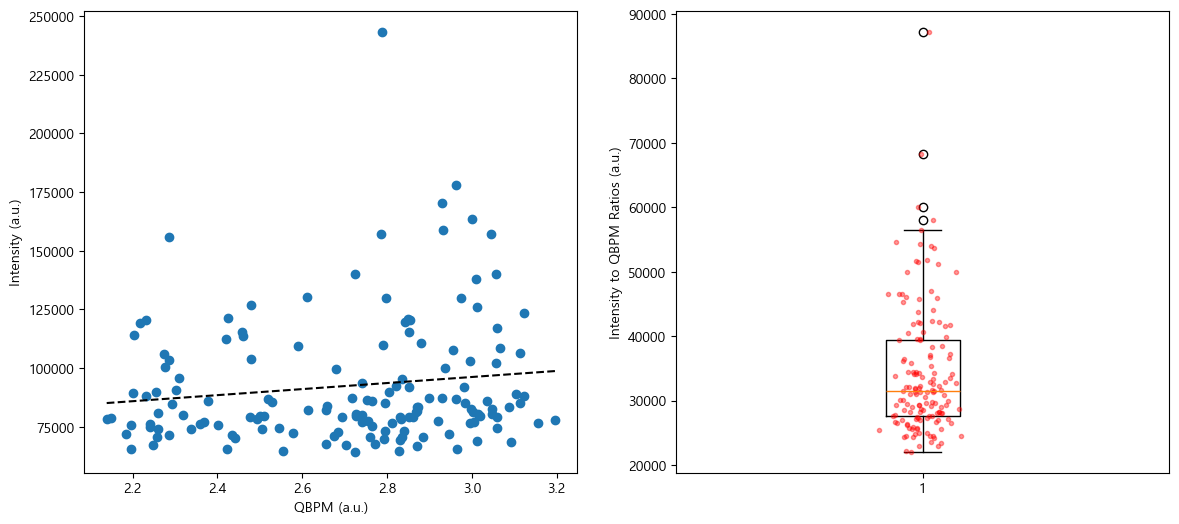

In [16]:
signal_ratios = poff_intensities / pon_qbpms
slop, y_intercept = np.polyfit(pon_qbpms, poff_intensities, 1)
x_minmax = np.array([pon_qbpms.min(), pon_qbpms.max()])
fit_y = slop * x_minmax + y_intercept
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].scatter(pon_qbpms, poff_intensities)
axs[0].plot(x_minmax, fit_y, 'k--')
axs[0].set_xlabel("QBPM (a.u.)")
axs[0].set_ylabel("Intensity (a.u.)")
axs[1].boxplot([signal_ratios])
x = np.random.normal(1, 0.03, size=len(signal_ratios))
axs[1].plot(x, signal_ratios, 'r.', alpha=0.4)
axs[1].set_ylabel("Intensity to QBPM Ratios (a.u.)")

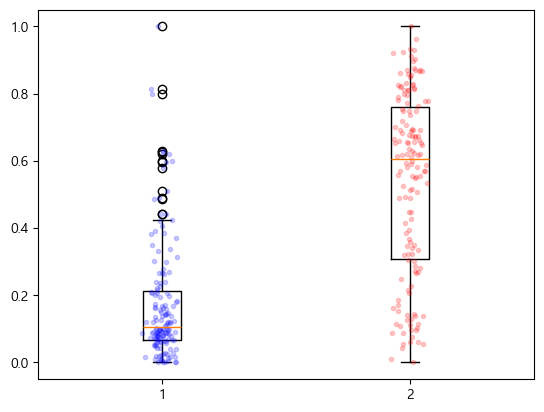

In [17]:
from src.mathematics import min_max_scale


roi_rect = RoiRectangle(x1=379, y1=123, x2=394, y2=136)
intensities = pon_images.sum(axis=(1, 2))

intensities_norm = min_max_scale(intensities)
qbpms_norm = min_max_scale(pon_qbpms)

fig, ax = plt.subplots(1, 1)
ax.boxplot([intensities_norm, qbpms_norm])

x = np.random.normal(1, 0.03, size=len(intensities))
ax.plot(x, intensities_norm, 'b.', alpha=0.2)
x = np.random.normal(2, 0.03, size=len(pon_qbpms))
ax.plot(x, qbpms_norm, 'r.', alpha=0.2)

In [18]:
from src.preprocessor.image_qbpm_preprocessor import (
    ImagesQbpmProcessor,
    make_qbpm_roi_normalizer,
    make_thresholder,
    # subtract_dark_background,
)
from src.functional import compose


roi_rect = RoiRectangle(x1=379, y1=123, x2=394, y2=136)
filter_and_normalize_by_qbpm = make_qbpm_roi_normalizer(roi_rect)
threshold4 = make_thresholder(4)
# compose make a function that exicuted from right to left
preprocessor = compose(
    # threshold4,
    filter_and_normalize_by_qbpm,
    # subtract_dark_background
)

result_images, _ = preprocessor([poff_images, qbpms])
print(result_images.shape)
result_image = rect.slice(np.sum(result_images, axis=0))
result_image = min_max_scale(result_image)
summed_image = min_max_scale(summed_image)

fig, axs = plt.subplots(1, 2, figsize=(8, 5))
axs[0].imshow(np.log(result_image + 0.001))
axs[1].imshow(np.log(summed_image + 0.001))

NameError: name 'qbpms' is not defined